In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix

%matplotlib inline
np.random.seed(42)

data = pd.read_csv("./fashionmnist/fashion-mnist_train.csv")

## Lecture des données 

In [2]:
# recupération des données
X = data.iloc[:,1:].values
y = data.iloc[:,0].values

In [3]:
# fonction d'affichage des images
def plot_data(centers,vmin,vmax):
    f, axarr = plt.subplots(1,centers.shape[0], sharex=True,sharey=True)
    for i in range(centers.shape[0]):
        axarr[i].imshow(centers[i,].reshape([28,28]),cmap='Greys',clim=(vmin, vmax),interpolation='nearest')
        axarr[i].set(aspect='equal')
        axarr[i].get_xaxis().set_visible(False)
        axarr[i].get_yaxis().set_visible(False)

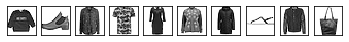

In [4]:
# les 10 premières images
plot_data(X[0:10,],0,255)

In [5]:
# les labels associés
y

array([2, 9, 6, ..., 8, 8, 7])

In [6]:
# creation d'une fonction permetant de passer d'une représentation numéro a une représentation binaire 
# ex : 2 -> [0,1,0,0,...]
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(y.reshape(-1,1))

/home/eetie/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=True)

In [7]:
# separation du jeu de données en train / test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [8]:
# creation d'un scaller permttant de centrer scaler les images
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_centered = scaler.transform(np.array(X_train,np.float))
X_test_centered  = scaler.transform(np.array(X_test,np.float))

/home/eetie/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [9]:
# passage des y en représentation binaire
Ybin_train = enc.transform(y_train.reshape(-1,1)).todense()
Ybin_test = enc.transform(y_test.reshape(-1,1)).todense()

## MLP entrée = vecteurs centré -réduit 

In [10]:
# definition d'un mlp avec keras
from keras.layers import Layer,Input, Dense
from keras.models import Model


inputs = Input(shape=(X.shape[1],)) 

hidden = Dense(32,activation='relu')(inputs)

outputs = Dense(10, activation='softmax')(hidden)

model1 = Model(inputs,outputs)

Using TensorFlow backend.


In [11]:
# compilation du model
model1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
# apprentissage
nbepoch = 25
hist = model1.fit(X_train_centered,Ybin_train,batch_size=20,epochs=nbepoch,validation_data=[X_test_centered,Ybin_test])

Train on 42000 samples, validate on 18000 samples
Epoch 1/25
42000/42000 [==============================] - 5s 108us/step - loss: 0.4897 - acc: 0.8234 - val_loss: 0.3970 - val_acc: 0.8577
Epoch 2/25
42000/42000 [==============================] - 4s 96us/step - loss: 0.3727 - acc: 0.8661 - val_loss: 0.3853 - val_acc: 0.8601
Epoch 3/25
42000/42000 [==============================] - 4s 90us/step - loss: 0.3357 - acc: 0.8767 - val_loss: 0.3706 - val_acc: 0.8689
Epoch 4/25
42000/42000 [==============================] - 4s 91us/step - loss: 0.3123 - acc: 0.8860 - val_loss: 0.3641 - val_acc: 0.8724
Epoch 5/25
42000/42000 [==============================] - 5s 109us/step - loss: 0.2960 - acc: 0.8905 - val_loss: 0.3617 - val_acc: 0.8703
Epoch 6/25
42000/42000 [==============================] - 4s 107us/step - loss: 0.2807 - acc: 0.8968 - val_loss: 0.3745 - val_acc: 0.8679
Epoch 7/25
42000/42000 [==============================] - 5s 113us/step - loss: 0.2682 - acc: 0.9023 - val_loss: 0.3681 - val

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (16,8)

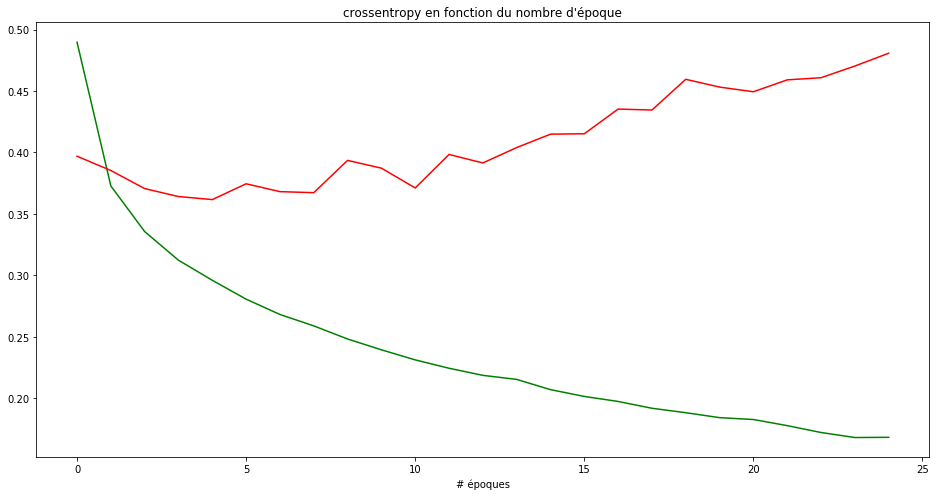

In [14]:
# affichage des résultat de l'apprentissage en terme de cross_entropy
h=plt.plot(range(nbepoch),hist.history["loss"],'-g',label='Train loss')
h=plt.plot(range(nbepoch),hist.history["val_loss"],'-r',label='Test loss')
h=plt.title(u"crossentropy en fonction du nombre d'époque")
h=plt.xlabel(u"# époques")

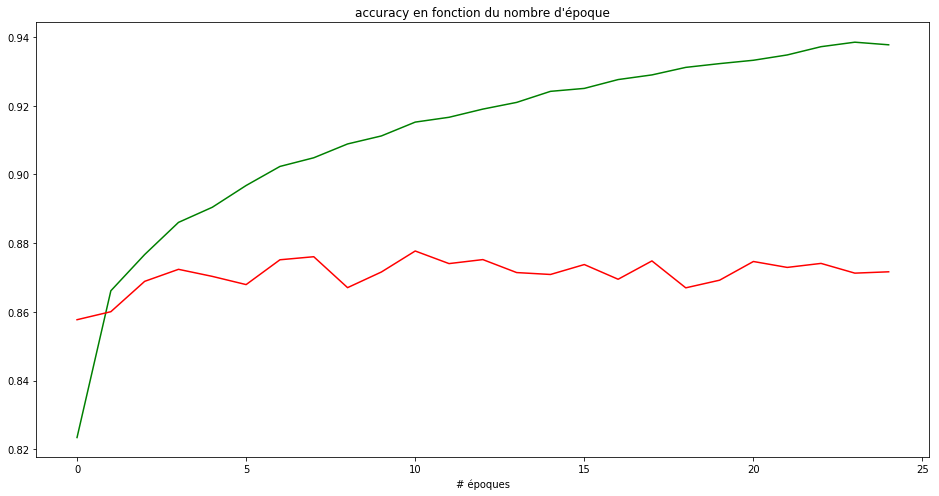

In [15]:
# affichage des résultat de l'apprentissage en terme d'accuracy
h=plt.plot(range(nbepoch),hist.history["acc"],'-g',label='Train accuracy')
h=plt.plot(range(nbepoch),hist.history["val_acc"],'-r',label='Test accuracy')
h=plt.title(u"accuracy en fonction du nombre d'époque")
h=plt.xlabel(u"# époques")

## ConvNN entrée = images

In [16]:
# mise en forme des données sous forme d'image 
Xim_train=X_train.reshape(X_train.shape[0],28,28,1)
Xim_test=X_test.reshape(X_test.shape[0],28,28,1)

In [17]:
from keras.layers import BatchNormalization,Conv2D,Flatten,MaxPooling2D,Dropout

inputs = Input(shape=(Xim_train.shape[1],Xim_train.shape[2],1))

inn = BatchNormalization()(inputs)

conv1 = Conv2D(64, (4, 4),  activation='relu')(inn)

p1 = MaxPooling2D(pool_size=(2, 2))(conv1)

d1 = Dropout(0.2)(p1)

conv2 = Conv2D(64, (4, 4),  activation='relu')(d1)

p2 = MaxPooling2D(pool_size=(2, 2))(conv2)

d2 = Dropout(0.1)(p2)

ifl = Flatten()(d2)

hidden1 = Dense(100,activation='relu')(ifl)

hd1 = Dropout(0.1)(hidden1)

hidden2 = Dense(30,activation='relu')(hd1)

hd2 = Dropout(0.1)(hidden2)

outputs = Dense(10, activation='softmax')(hd2)

model2 = Model(inputs,outputs)


In [18]:
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
nbepoch = 10
hist = model2.fit(Xim_train,Ybin_train,batch_size=20,epochs=nbepoch,validation_data=[Xim_test,Ybin_test])

Train on 42000 samples, validate on 18000 samples
Epoch 1/10
42000/42000 [==============================] - 107s 3ms/step - loss: 0.5935 - acc: 0.7820 - val_loss: 0.3909 - val_acc: 0.8626
Epoch 2/10
42000/42000 [==============================] - 108s 3ms/step - loss: 0.4000 - acc: 0.8553 - val_loss: 0.3432 - val_acc: 0.8759
Epoch 3/10
42000/42000 [==============================] - 104s 2ms/step - loss: 0.3511 - acc: 0.8743 - val_loss: 0.3072 - val_acc: 0.8881
Epoch 4/10
42000/42000 [==============================] - 104s 2ms/step - loss: 0.3216 - acc: 0.8835 - val_loss: 0.2994 - val_acc: 0.8906
Epoch 5/10
42000/42000 [==============================] - 104s 2ms/step - loss: 0.3000 - acc: 0.8901 - val_loss: 0.3022 - val_acc: 0.8849
Epoch 6/10
42000/42000 [==============================] - 104s 2ms/step - loss: 0.2830 - acc: 0.8953 - val_loss: 0.2837 - val_acc: 0.9003
Epoch 7/10
42000/42000 [==============================] - 106s 3ms/step - loss: 0.2709 - acc: 0.8988 - val_loss: 0.3083 - 

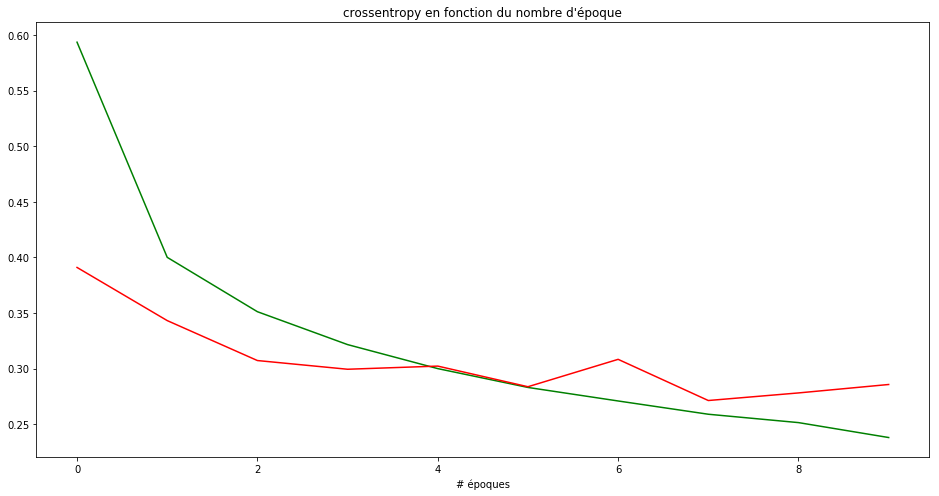

In [20]:
h=plt.plot(range(nbepoch),hist.history["loss"],'-g',label='Train loss')
h=plt.plot(range(nbepoch),hist.history["val_loss"],'-r',label='Test loss')
h=plt.title(u"crossentropy en fonction du nombre d'époque")
h=plt.xlabel(u"# époques")

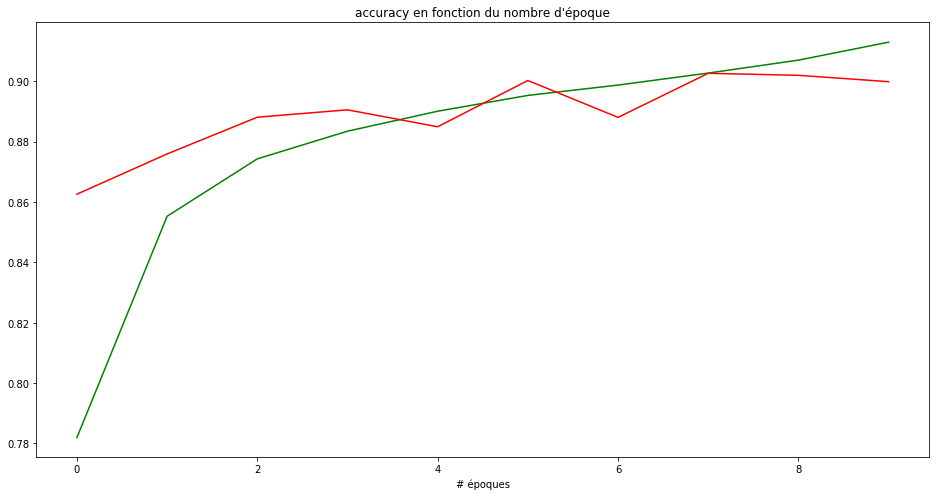

In [21]:
h=plt.plot(range(nbepoch),hist.history["acc"],'-g',label='Train accuracy')
h=plt.plot(range(nbepoch),hist.history["val_acc"],'-r',label='Test accuracy')
h=plt.title(u"accuracy en fonction du nombre d'époque")
h=plt.xlabel(u"# époques")

In [22]:
# performances sur les données de test ?
evaluation = model2.evaluate(Xim_test,Ybin_test)

18000/18000 [==============================] - 13s 704us/step


In [23]:
evaluation

[0.28569498003522553, 0.8998888888888888]

# Questions
## 1) Essayer différentes architectures de réseau et comparer les résultats
## 2) Faites varier les paramètre de l'optimisation et comparer les résultats
## 3) Essayé de construire et d'estimer un auto-encoder a 3 couches cachées [15,2,15] [relu,lin,relu] et visualiser le résultats de la projection. en coloriant les points suivant leurs classes